In [3]:
import csv
import pandas as pd

import os
import sys

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
from experiments.pretraining_vs_finetuning.volume_of_finetuning.volume_buckets import finetuning_proportion_buckets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 17209.52it/s]


0.5053165780570323 1.000560857431749
0.5050749154180764 0.9973967685029146
0.5227162880618657 0.8062796269547329
0.6892218463025617 0.6462009564917051
0.7438376027066216 0.5619453092700474


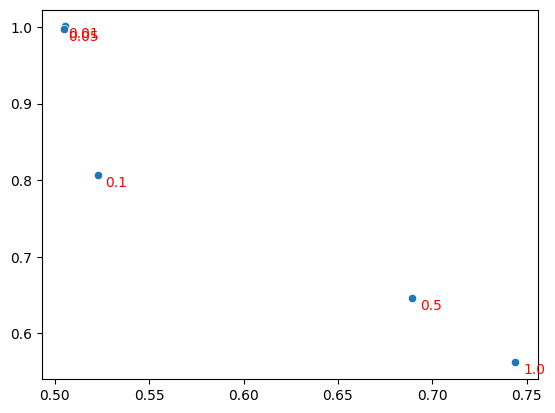

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
x = []
y = []

for prop, datasets in finetuning_proportion_buckets.items():
    acc = datasets['atomic-test'].accuracy
    var_explained = datasets['atomic-human'].law_of_total_variance_breakdown()['prop_explained']
    
    x.append(acc)
    y.append(var_explained)

    print(acc, var_explained)

sns.scatterplot(x=x, y=y)
for i, words in enumerate(list(finetuning_proportion_buckets.keys())):
    plt.text(x[i]+0.01, y[i]-0.01, words, fontsize=10, ha='center', va='center', color='red')


In [25]:
for b in finetuning_proportion_buckets[0.01]['atomic-human'].buckets:
    print([p.correct for p in b.paraphrase_predictions])

[0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1]
[1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0]
[1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0,